# Papers
* EfficientNetV1: https://arxiv.org/abs/1905.11946
* EfficientNetV2: https://arxiv.org/abs/2104.00298

# Setup

In [ ]:
import cv2
import numpy as np
import torch
from math import ceil
from PIL.Image import Image
from torch import nn
import matplotlib.pyplot as plt

# Prepare data (Kaggle)

* Source: https://www.kaggle.com/datasets/shiekhburhan/face-mask-dataset

The dataset has a total of 14535 images. It can be primarily used to train face mask classifiers.
It consists of 3 classes.
a) Incorrect mask b)With mask C) without mask.

incorrect masked class consists of 5000 images, of which 2500 are MaskonChin and 2500 are Mask_on _Mouth_Chin.

With mask class has 4789 images, of which 4000 are simple with mask and 789 are complex
with mask images.

without mask has 4746 images, of which 4000 are simple and 746 are complex images.

The primary purpose of creating such a dataset is to help a researcher to develop a face mask detection system that can detect almost all types of face masks with different orientations.

The various types of images used in the dataset are as follows:

* "MaskOnChin" images: These are the images in which masks are put on a chin only. The mouth and the nose of a person are visible.
* "MaskOnChinMouth" images: In this, the mask is covering the chin and the mouth area. The nose of a person is not covered.
* "Simple WithMask" images:- It consists of data samples of face masks without any texture, logos, etc.
* "Complex WithMask" images: It includes the images of the sophisticated face masks with textures, logos, or designs printed on them.
* "Simple WithoutMask images: These are images without any occlusion.
* "complex WithoutMask" images: It consists of faces with occlusion, such as beard, hair, and hands covering the face.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from pathlib import Path
import os
import pandas as pd
import numpy as np

In [ ]:
data_dir = "/content/drive/MyDrive/Colab Notebooks/COMP4471/Project/facemask"

In [ ]:
with_mask_dir = Path(data_dir+"/with_mask/simple")
mc_dir = Path(data_dir+"/incorrect_mask/mc")
mmc_dir = Path(data_dir+"/incorrect_mask/mmc")
without_mask_dir = Path(data_dir+"/without_mask/simple")


with_mask = list(with_mask_dir.glob(r'*jpg'))
mc = list(mc_dir.glob(r'*jpg'))
mmc = list(mmc_dir.glob(r'*jpg'))
incorrect_mask = mc+mmc
without_mask = list(without_mask_dir.glob(r'*jpg'))

len(with_mask), len(incorrect_mask), len(without_mask)

(4000, 5000, 4000)

In [ ]:
def generate_df(image_dir, label):
    filepath = pd.Series(image_dir, name='Filepath').astype(str)
    labels = pd.Series(label, name='Label', index=filepath.index).astype(str)
    df = pd.concat([filepath, labels], axis=1)
    return df

In [ ]:
with_mask_df = generate_df(with_mask, label=0)
incorrect_mask_df = generate_df(incorrect_mask, label=1)
without_mask_df = generate_df(without_mask, label=2)
total_df = pd.concat([with_mask_df, incorrect_mask_df, without_mask_df], axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)
total_df.head()

,Filepath,Label
0,/content/drive/MyDrive/Colab Notebooks/COMP447...,0
1,/content/drive/MyDrive/Colab Notebooks/COMP447...,2
2,/content/drive/MyDrive/Colab Notebooks/COMP447...,1
3,/content/drive/MyDrive/Colab Notebooks/COMP447...,0
4,/content/drive/MyDrive/Colab Notebooks/COMP447...,1


In [ ]:
total_df.shape

(13000, 2)

## Build a custom Dataset

In [ ]:
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.io import read_image

class FaceMaskDataset(Dataset):
    def __init__(self, dir_label_df, transform=None):
        self.dir_label_df = dir_label_df
        self.transform = transform

    def __len__(self):
        return self.dir_label_df.shape[0]

    def __getitem__(self, idx):
        img_path = self.dir_label_df["Filepath"][idx]
        image = read_image(img_path)/255
        label = torch.as_tensor([int(self.dir_label_df["Label"][idx])])
        if self.transform:
            image = self.transform(image.type(torch.DoubleTensor))
        return image, label

In [ ]:
import torchvision.transforms as transforms

img_size = 224

transform = transforms.Compose(
    [transforms.Resize((img_size,img_size)),
    transforms.Normalize((0.5, 0.5, 0.5), (0.2, 0.2, 0.2))])

all_data = FaceMaskDataset(total_df, transform=transform)
len(all_data), all_data[0][0].shape, all_data[0][1], float(all_data[0][0].max()), float(all_data[0][0].min())

(13000, torch.Size([3, 224, 224]), tensor([0]), 2.5, -2.5)

In [ ]:
from torch.utils.data import random_split

train_data, valid_data, test_data = random_split(all_data, [10000, 1000, 2000],
                                                 generator=torch.Generator().manual_seed(0))
len(train_data), len(valid_data), len(test_data), train_data[0][0].shape, train_data[0][1]

(10000, 1000, 2000, torch.Size([3, 224, 224]), tensor([0]))

In [ ]:
batch_size = 16

train_loader = DataLoader(all_data, batch_size=batch_size)
val_loader = DataLoader(valid_data, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=batch_size)

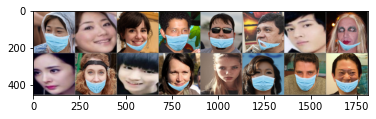

tensor([0, 2, 1, 0, 1, 1, 2, 1, 2, 1, 2, 1, 2, 0, 0, 1])

In [ ]:
from torchvision.utils import make_grid

# functions to show an image

def imshow(img):
    img = img * 0.2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(make_grid(images))
# print labels
#print(' '.join(f'{labels[j]}' for j in range(batch_size)))
labels.squeeze(1)

# Model modules

In [ ]:
# for __init__.py
# from .classification import EfficientNet, VALID_MODELS

## Utils

In [ ]:
import re
import math
import collections
from functools import partial
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils import model_zoo

# GlobalParams and BlockArgs: Two namedtuples
# Swish and MemoryEfficientSwish: Two implementations of the method
# round_filters and round_repeats:
#     Functions to calculate params for scaling model width and depth
# get_width_and_height_from_size and calculate_output_image_size
# drop_connect: A structural design

# Parameters for the entire model (stem, all blocks, and head)
GlobalParams = collections.namedtuple('GlobalParams', [
    'width_coefficient', 'depth_coefficient', 'image_size', 'dropout_rate',
    'num_classes', 'batch_norm_momentum', 'batch_norm_epsilon',
    'drop_connect_rate', 'depth_divisor', 'min_depth', 'include_top'])

# Parameters for an individual model block
BlockArgs = collections.namedtuple('BlockArgs', [
    'num_repeat', 'kernel_size', 'stride', 'expand_ratio',
    'input_filters', 'output_filters', 'se_ratio', 'id_skip'])

# Set GlobalParams and BlockArgs's defaults to all None
GlobalParams.__new__.__defaults__ = (None,) * len(GlobalParams._fields)
BlockArgs.__new__.__defaults__ = (None,) * len(BlockArgs._fields)

### Swish

In [ ]:
# Swish activation function
Swish = nn.SiLU


# A memory-efficient implementation of Swish function
class SwishImplementation(torch.autograd.Function):
    @staticmethod
    def forward(ctx, i):
        result = i * torch.sigmoid(i)
        ctx.save_for_backward(i)
        return result

    @staticmethod
    def backward(ctx, grad_output):
        i = ctx.saved_tensors[0]
        sigmoid_i = torch.sigmoid(i)
        return grad_output * (sigmoid_i * (1 + i * (1 - sigmoid_i)))


class MemoryEfficientSwish(nn.Module):
    def forward(self, x):
        return SwishImplementation.apply(x)

### Padding

In [ ]:
def get_same_padding_conv2d(image_size=None):
    """
    Args:
        image_size (int or tuple): Size of the image.
    Returns:
        Conv2dDynamicSamePadding
    """
    
    return partial(Conv2dStaticSamePadding, image_size=image_size)


class Conv2dStaticSamePadding(nn.Conv2d):
    """2D Convolutions with 'SAME' mode, with the given input image size.
       The padding mudule is calculated in construction function, then used in forward.
    """

    # With the same calculation as Conv2dDynamicSamePadding

    def __init__(self, in_channels, out_channels, kernel_size, stride=1, image_size=None, **kwargs):
        super().__init__(in_channels, out_channels, kernel_size, stride, **kwargs)
        self.stride = self.stride if len(self.stride) == 2 else [self.stride[0]] * 2

        # Calculate padding based on image size and save it
        assert image_size is not None
        ih, iw = (image_size, image_size) if isinstance(image_size, int) else image_size
        kh, kw = self.weight.size()[-2:]
        sh, sw = self.stride
        oh, ow = math.ceil(ih / sh), math.ceil(iw / sw)
        pad_h = max((oh - 1) * self.stride[0] + (kh - 1) * self.dilation[0] + 1 - ih, 0)
        pad_w = max((ow - 1) * self.stride[1] + (kw - 1) * self.dilation[1] + 1 - iw, 0)
        if pad_h > 0 or pad_w > 0:
            self.static_padding = nn.ZeroPad2d((pad_w // 2, pad_w - pad_w // 2,
                                                pad_h // 2, pad_h - pad_h // 2))
        else:
            self.static_padding = nn.Identity()

    def forward(self, x):
        x = self.static_padding(x)
        x = F.conv2d(x, self.weight, self.bias, self.stride, self.padding, self.dilation, self.groups)
        return x

### Model params, weights
Helper functions for loading model params
* BlockDecoder: A Class for encoding and decoding BlockArgs
* efficientnet_params: A function to query compound coefficient
* get_model_params and efficientnet: Functions to get BlockArgs and GlobalParams for efficientnet
* load_pretrained_weights: A function to load pretrained weights

In [ ]:
################################################################################
# Helper functions for loading model params
################################################################################

# BlockDecoder: A Class for encoding and decoding BlockArgs
# efficientnet_params: A function to query compound coefficient
# get_model_params and efficientnet:
#     Functions to get BlockArgs and GlobalParams for efficientnet
# load_pretrained_weights: A function to load pretrained weights

class BlockDecoder(object):
    """Block Decoder for readability,
       straight from the official TensorFlow repository.
    """

    @staticmethod
    def _decode_block_string(block_string):
        """Get a block through a string notation of arguments.

        Args:
            block_string (str): A string notation of arguments.
                                Examples: 'r1_k3_s11_e1_i32_o16_se0.25_noskip'.

        Returns:
            BlockArgs: The namedtuple defined at the top of this file.
        """
        assert isinstance(block_string, str)

        ops = block_string.split('_')
        options = {}
        for op in ops:
            splits = re.split(r'(\d.*)', op)
            if len(splits) >= 2:
                key, value = splits[:2]
                options[key] = value

        # Check stride
        assert (('s' in options and len(options['s']) == 1) or
                (len(options['s']) == 2 and options['s'][0] == options['s'][1]))

        return BlockArgs(
            num_repeat=int(options['r']),
            kernel_size=int(options['k']),
            stride=[int(options['s'][0])],
            expand_ratio=int(options['e']),
            input_filters=int(options['i']),
            output_filters=int(options['o']),
            se_ratio=float(options['se']) if 'se' in options else None,
            id_skip=('noskip' not in block_string))

    @staticmethod
    def _encode_block_string(block):
        """Encode a block to a string.

        Args:
            block (namedtuple): A BlockArgs type argument.

        Returns:
            block_string: A String form of BlockArgs.
        """
        args = [
            'r%d' % block.num_repeat,
            'k%d' % block.kernel_size,
            's%d%d' % (block.strides[0], block.strides[1]),
            'e%s' % block.expand_ratio,
            'i%d' % block.input_filters,
            'o%d' % block.output_filters
        ]
        if 0 < block.se_ratio <= 1:
            args.append('se%s' % block.se_ratio)
        if block.id_skip is False:
            args.append('noskip')
        return '_'.join(args)

    @staticmethod
    def decode(string_list):
        """Decode a list of string notations to specify blocks inside the network.

        Args:
            string_list (list[str]): A list of strings, each string is a notation of block.

        Returns:
            blocks_args: A list of BlockArgs namedtuples of block args.
        """
        assert isinstance(string_list, list)
        blocks_args = []
        for block_string in string_list:
            blocks_args.append(BlockDecoder._decode_block_string(block_string))
        return blocks_args

    @staticmethod
    def encode(blocks_args):
        """Encode a list of BlockArgs to a list of strings.

        Args:
            blocks_args (list[namedtuples]): A list of BlockArgs namedtuples of block args.

        Returns:
            block_strings: A list of strings, each string is a notation of block.
        """
        block_strings = []
        for block in blocks_args:
            block_strings.append(BlockDecoder._encode_block_string(block))
        return block_strings


def efficientnet_params(model_name):
    """Map EfficientNet model name to parameter coefficients.

    Args:
        model_name (str): Model name to be queried.

    Returns:
        params_dict[model_name]: A (width,depth,res,dropout) tuple.
    """
    params_dict = {
        # Coefficients:   width,depth,res,dropout
        'efficientnet-b0': (1.0, 1.0, 224, 0.2),
        'efficientnet-b1': (1.0, 1.1, 240, 0.2),
        'efficientnet-b2': (1.1, 1.2, 260, 0.3),
        'efficientnet-b3': (1.2, 1.4, 300, 0.3),
        'efficientnet-b4': (1.4, 1.8, 380, 0.4),
        'efficientnet-b5': (1.6, 2.2, 456, 0.4),
        'efficientnet-b6': (1.8, 2.6, 528, 0.5),
        'efficientnet-b7': (2.0, 3.1, 600, 0.5),
    }
    return params_dict[model_name]


def efficientnet(width_coefficient=None, depth_coefficient=None, image_size=None,
                 dropout_rate=0.2, drop_connect_rate=0.2, num_classes=3, include_top=True):
    """Create BlockArgs and GlobalParams for efficientnet model.

    Args:
        width_coefficient (float)
        depth_coefficient (float)
        image_size (int)
        dropout_rate (float)
        drop_connect_rate (float)
        num_classes (int)

        Meaning as the name suggests.

    Returns:
        blocks_args, global_params.
    """

    # Blocks args for the whole model(efficientnet-b0 by default)
    # It will be modified in the construction of EfficientNet Class according to model
    blocks_args = [
        'r1_k3_s11_e1_i32_o16_se0.25',
        'r2_k3_s22_e6_i16_o24_se0.25',
        'r2_k5_s22_e6_i24_o40_se0.25',
        'r3_k3_s22_e6_i40_o80_se0.25',
        'r3_k5_s11_e6_i80_o112_se0.25',
        'r4_k5_s22_e6_i112_o192_se0.25',
        'r1_k3_s11_e6_i192_o320_se0.25',
    ]
    blocks_args = BlockDecoder.decode(blocks_args)

    global_params = GlobalParams(
        width_coefficient=width_coefficient,
        depth_coefficient=depth_coefficient,
        image_size=image_size,
        dropout_rate=dropout_rate,

        num_classes=num_classes,
        batch_norm_momentum=0.99,
        batch_norm_epsilon=1e-3,
        drop_connect_rate=drop_connect_rate,
        depth_divisor=8,
        min_depth=None,
        include_top=include_top,
    )

    return blocks_args, global_params


def get_model_params(model_name, override_params):
    """Get the block args and global params for a given model name.

    Args:
        model_name (str): Model's name.
        override_params (dict): A dict to modify global_params.

    Returns:
        blocks_args, global_params
    """
    if model_name.startswith('efficientnet'):
        w, d, s, p = efficientnet_params(model_name)
        # note: all models have drop connect rate = 0.2
        blocks_args, global_params = efficientnet(
            width_coefficient=w, depth_coefficient=d, dropout_rate=p, image_size=s)
    else:
        raise NotImplementedError('model name is not pre-defined: {}'.format(model_name))
    if override_params:
        # ValueError will be raised here if override_params has fields not included in global_params.
        global_params = global_params._replace(**override_params)
    return blocks_args, global_params


def load_weights(model, weights_path=None, online=False, load_fc=True, verbose=True):
    """Loads weights from weights path or download using url.

    Args:
        model (Module): The whole skeleton model of efficientnet.
        weights_path (str):
            online=False: path to pretrained weights file on the local disk.
            online=True: use weights downloaded from the Internet.
        load_fc (bool): Whether to load pretrained weights for fc layer at the end of the model.
    """
    if not online:
        state_dict = torch.load(weights_path)
    else:
        state_dict = model_zoo.load_url(weights_path)

    if load_fc:
        ret = model.load_state_dict(state_dict, strict=False)
        assert not ret.missing_keys, 'Missing keys when loading pretrained weights: {}'.format(ret.missing_keys)
    else:
        state_dict.pop('_fc.weight')
        state_dict.pop('_fc.bias')
        ret = model.load_state_dict(state_dict, strict=False)
        assert set(ret.missing_keys) == set(
            ['_fc.weight', '_fc.bias']), 'Missing keys when loading pretrained weights: {}'.format(ret.missing_keys)
    assert not ret.unexpected_keys, 'Missing keys when loading pretrained weights: {}'.format(ret.unexpected_keys)

    if verbose:
        print('Finish loading weights')

### Miscellaneous

In [ ]:
def round_filters(filters, global_params):
    """Calculate and round number of filters based on width multiplier.
       Use width_coefficient, depth_divisor and min_depth of global_params.

    Args:
        filters (int): Filters number to be calculated.
        global_params (namedtuple): Global params of the model.

    Returns:
        new_filters: New filters number after calculating.
    """
    multiplier = global_params.width_coefficient
    if not multiplier:
        return filters

    divisor = global_params.depth_divisor
    min_depth = global_params.min_depth
    filters *= multiplier
    min_depth = min_depth or divisor  # pay attention to this line when using min_depth
    # follow the formula transferred from official TensorFlow implementation
    new_filters = max(min_depth, int(filters + divisor / 2) // divisor * divisor)
    if new_filters < 0.9 * filters:  # prevent rounding by more than 10%
        new_filters += divisor
    return int(new_filters)


def round_repeats(repeats, global_params):
    """Calculate module's repeat number of a block based on depth multiplier.
       Use depth_coefficient of global_params.

    Args:
        repeats (int): num_repeat to be calculated.
        global_params (namedtuple): Global params of the model.

    Returns:
        new repeat: New repeat number after calculating.
    """
    multiplier = global_params.depth_coefficient
    if not multiplier:
        return repeats
    # follow the formula transferred from official TensorFlow implementation
    return int(math.ceil(multiplier * repeats))


def drop_connect(inputs, p, training):
    """Drop connect.

    Args:
        input (tensor: BCWH): Input of this structure.
        p (float: 0.0~1.0): Probability of drop connection.
        training (bool): The running mode.

    Returns:
        output: Output after drop connection.
    """
    assert 0 <= p <= 1, 'p must be in range of [0,1]'

    if not training:
        return inputs

    batch_size = inputs.shape[0]
    keep_prob = 1 - p

    # generate binary_tensor mask according to probability (p for 0, 1-p for 1)
    random_tensor = keep_prob
    random_tensor += torch.rand([batch_size, 1, 1, 1], dtype=inputs.dtype, device=inputs.device)
    binary_tensor = torch.floor(random_tensor)

    output = inputs / keep_prob * binary_tensor
    return output


def get_width_and_height_from_size(x):
    """Obtain height and width from x.

    Args:
        x (int, tuple or list): Data size.

    Returns:
        size: A tuple or list (H,W).
    """
    if isinstance(x, int):
        return x, x
    if isinstance(x, list) or isinstance(x, tuple):
        return x
    else:
        raise TypeError()


def calculate_output_image_size(input_image_size, stride):
    """Calculates the output image size when using Conv2dSamePadding with a stride.
       Necessary for static padding. Thanks to mannatsingh for pointing this out.

    Args:
        input_image_size (int, tuple or list): Size of input image.
        stride (int, tuple or list): Conv2d operation's stride.

    Returns:
        output_image_size: A list [H,W].
    """
    if input_image_size is None:
        return None
    image_height, image_width = get_width_and_height_from_size(input_image_size)
    stride = stride if isinstance(stride, int) else stride[0]
    image_height = int(math.ceil(image_height / stride))
    image_width = int(math.ceil(image_width / stride))
    return [image_height, image_width]

## Model class

<img src="https://miro.medium.com/max/4800/0*WP4AKPg1QsrMCKKO.png" alt="Architecture info" width="500"/>


In [ ]:
import torch
from torch import nn
from torch.nn import functional as F

### MBConvBlock 

In [ ]:
class MBConvBlock(nn.Module):
    """Mobile Inverted Residual Bottleneck Block.

    Args:
        block_args (namedtuple): BlockArgs, defined in utils.py.
        global_params (namedtuple): GlobalParam, defined in utils.py.
        image_size (tuple or list): [image_height, image_width].
    """

    def __init__(self, block_args, global_params, image_size=None):
        super().__init__()
        self._block_args = block_args
        self._bn_mom = 1 - global_params.batch_norm_momentum  
        self._bn_eps = global_params.batch_norm_epsilon
        self.has_se = (self._block_args.se_ratio is not None) and (0 < self._block_args.se_ratio <= 1)
        self.id_skip = block_args.id_skip  # whether to use skip connection and drop connect

        # Expansion phase (Inverted Bottleneck)
        inp = self._block_args.input_filters  # number of input channels
        oup = self._block_args.input_filters * self._block_args.expand_ratio  # number of output channels
        if self._block_args.expand_ratio != 1:
            Conv2d = get_same_padding_conv2d(image_size=image_size)
            self._expand_conv = Conv2d(in_channels=inp, out_channels=oup, kernel_size=1, bias=False)
            self._bn0 = nn.BatchNorm2d(num_features=oup, momentum=self._bn_mom, eps=self._bn_eps)

        # Depthwise convolution phase
        k = self._block_args.kernel_size
        s = self._block_args.stride
        Conv2d = get_same_padding_conv2d(image_size=image_size)
        self._depthwise_conv = Conv2d(
            in_channels=oup, out_channels=oup, groups=oup,  # groups makes it depthwise
            kernel_size=k, stride=s, bias=False)
        self._bn1 = nn.BatchNorm2d(num_features=oup, momentum=self._bn_mom, eps=self._bn_eps)
        image_size = calculate_output_image_size(image_size, s)

        # Squeeze and Excitation layer if needed
        if self.has_se:
            Conv2d = get_same_padding_conv2d(image_size=(1, 1))
            num_squeezed_channels = max(1, int(self._block_args.input_filters * self._block_args.se_ratio))
            self._se_reduce = Conv2d(in_channels=oup, out_channels=num_squeezed_channels, kernel_size=1)
            self._se_expand = Conv2d(in_channels=num_squeezed_channels, out_channels=oup, kernel_size=1)

        # Pointwise convolution phase
        final_oup = self._block_args.output_filters
        Conv2d = get_same_padding_conv2d(image_size=image_size)
        self._project_conv = Conv2d(in_channels=oup, out_channels=final_oup, kernel_size=1, bias=False)
        self._bn2 = nn.BatchNorm2d(num_features=final_oup, momentum=self._bn_mom, eps=self._bn_eps)
        self._swish = MemoryEfficientSwish()

    def forward(self, inputs, drop_connect_rate=None):
        """MBConvBlock's forward function.

        Args:
            inputs (tensor): Input tensor.
            drop_connect_rate (bool): Drop connect rate (float, between 0 and 1).

        Returns:
            Output of this block after processing.
        """

        # Expansion and Depthwise Convolution
        x = inputs
        if self._block_args.expand_ratio != 1:
            x = self._expand_conv(inputs)
            x = self._bn0(x)
            x = self._swish(x)

        x = self._depthwise_conv(x)
        x = self._bn1(x)
        x = self._swish(x)

        # Squeeze and Excitation
        if self.has_se:
            x_squeezed = F.adaptive_avg_pool2d(x, 1)
            x_squeezed = self._se_reduce(x_squeezed)
            x_squeezed = self._swish(x_squeezed)
            x_squeezed = self._se_expand(x_squeezed)
            x = torch.sigmoid(x_squeezed) * x

        # Pointwise Convolution
        x = self._project_conv(x)
        x = self._bn2(x)

        # Skip connection and drop connect
        input_filters, output_filters = self._block_args.input_filters, self._block_args.output_filters
        if self.id_skip and self._block_args.stride == 1 and input_filters == output_filters:
            # The combination of skip connection and drop connect brings about stochastic depth.
            if drop_connect_rate:
                x = drop_connect(x, p=drop_connect_rate, training=self.training)
            x = x + inputs  # skip connection
        return x

    def set_swish(self, memory_efficient=True):
        """Sets swish function as memory efficient (for training) or standard (for export).

        Args:
            memory_efficient (bool): Whether to use memory-efficient version of swish.
        """
        self._swish = MemoryEfficientSwish() if memory_efficient else Swish()

### EfficientNet

In [ ]:
VALID_MODELS = (
    'efficientnet-b0', 'efficientnet-b1', 'efficientnet-b2', 'efficientnet-b3',
    'efficientnet-b4', 'efficientnet-b5', 'efficientnet-b6', 'efficientnet-b7',
)

In [ ]:
class EfficientNet(nn.Module):
    """EfficientNet model.
       Most easily loaded with the .from_name or .from_pretrained methods.

    Args:
        blocks_args (list[namedtuple]): A list of BlockArgs to construct blocks.
        global_params (namedtuple): A set of GlobalParams shared between blocks.
    """

    def __init__(self, blocks_args=None, global_params=None):
        super().__init__()
        assert isinstance(blocks_args, list), 'blocks_args should be a list'
        assert len(blocks_args) > 0, 'block args must be greater than 0'
        self._global_params = global_params
        self._blocks_args = blocks_args

        # Batch norm parameters
        bn_mom = 1 - self._global_params.batch_norm_momentum
        bn_eps = self._global_params.batch_norm_epsilon

        # Get stem static or dynamic convolution depending on image size
        image_size = global_params.image_size
        Conv2d = get_same_padding_conv2d(image_size=image_size)

        # Stem
        in_channels = 3  # rgb
        out_channels = round_filters(32, self._global_params)  # number of output channels
        self._conv_stem = Conv2d(in_channels, out_channels, kernel_size=3, stride=2, bias=False)
        self._bn0 = nn.BatchNorm2d(num_features=out_channels, momentum=bn_mom, eps=bn_eps)
        image_size = calculate_output_image_size(image_size, 2)

        # Build blocks
        self._blocks = nn.ModuleList([])
        for block_args in self._blocks_args:

            # Update block input and output filters based on depth multiplier.
            block_args = block_args._replace(
                input_filters=round_filters(block_args.input_filters, self._global_params),
                output_filters=round_filters(block_args.output_filters, self._global_params),
                num_repeat=round_repeats(block_args.num_repeat, self._global_params)
            )

            # The first block needs to take care of stride and filter size increase.
            self._blocks.append(MBConvBlock(block_args, self._global_params, image_size=image_size))
            image_size = calculate_output_image_size(image_size, block_args.stride)
            if block_args.num_repeat > 1:  # modify block_args to keep same output size
                block_args = block_args._replace(input_filters=block_args.output_filters, stride=1)
            for _ in range(block_args.num_repeat - 1):
                self._blocks.append(MBConvBlock(block_args, self._global_params, image_size=image_size))

        # Head
        in_channels = block_args.output_filters  # output of final block
        out_channels = round_filters(1280, self._global_params)
        Conv2d = get_same_padding_conv2d(image_size=image_size)
        self._conv_head = Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self._bn1 = nn.BatchNorm2d(num_features=out_channels, momentum=bn_mom, eps=bn_eps)

        # Final linear layer
        self._avg_pooling = nn.AdaptiveAvgPool2d(1)
        if self._global_params.include_top:
            self._dropout = nn.Dropout(self._global_params.dropout_rate)
            self._fc = nn.Linear(out_channels, self._global_params.num_classes)

        # set activation to memory efficient swish by default
        self._swish = MemoryEfficientSwish()

    def set_swish(self, memory_efficient=True):
        """Sets swish function as memory efficient (for training) or standard (for export).

        Args:
            memory_efficient (bool): Whether to use memory-efficient version of swish.
        """
        self._swish = MemoryEfficientSwish() if memory_efficient else Swish()
        for block in self._blocks:
            block.set_swish(memory_efficient)

    def extract_endpoints(self, inputs):
        """Use convolution layer to extract features
        from reduction levels i in [1, 2, 3, 4, 5].

        Args:
            inputs (tensor): Input tensor.

        Returns:
            Dictionary of last intermediate features
            with reduction levels i in [1, 2, 3, 4, 5].
            Example:
                >>> import torch
                >>> inputs = torch.rand(1, 3, 224, 224)
                >>> model = EfficientNet.from_pretrained('efficientnet-b0')
                >>> endpoints = model.extract_endpoints(inputs)
                >>> print(endpoints['reduction_1'].shape)  # torch.Size([1, 16, 112, 112])
                >>> print(endpoints['reduction_2'].shape)  # torch.Size([1, 24, 56, 56])
                >>> print(endpoints['reduction_3'].shape)  # torch.Size([1, 40, 28, 28])
                >>> print(endpoints['reduction_4'].shape)  # torch.Size([1, 112, 14, 14])
                >>> print(endpoints['reduction_5'].shape)  # torch.Size([1, 320, 7, 7])
                >>> print(endpoints['reduction_6'].shape)  # torch.Size([1, 1280, 7, 7])
        """
        endpoints = dict()

        # Stem
        x = self._swish(self._bn0(self._conv_stem(inputs)))
        prev_x = x

        # Blocks
        for idx, block in enumerate(self._blocks):
            drop_connect_rate = self._global_params.drop_connect_rate
            if drop_connect_rate:
                drop_connect_rate *= float(idx) / len(self._blocks)  # scale drop connect_rate
            x = block(x, drop_connect_rate=drop_connect_rate)
            if prev_x.size(2) > x.size(2):
                endpoints['reduction_{}'.format(len(endpoints) + 1)] = prev_x
            elif idx == len(self._blocks) - 1:
                endpoints['reduction_{}'.format(len(endpoints) + 1)] = x
            prev_x = x

        # Head
        x = self._swish(self._bn1(self._conv_head(x)))
        endpoints['reduction_{}'.format(len(endpoints) + 1)] = x

        return endpoints

    def extract_features(self, inputs):
        """use convolution layer to extract feature .

        Args:
            inputs (tensor): Input tensor.

        Returns:
            Output of the final convolution
            layer in the efficientnet model.
        """
        # Stem
        x = self._swish(self._bn0(self._conv_stem(inputs)))

        # Blocks
        for idx, block in enumerate(self._blocks):
            drop_connect_rate = self._global_params.drop_connect_rate
            if drop_connect_rate:
                drop_connect_rate *= float(idx) / len(self._blocks)  # scale drop connect_rate
            x = block(x, drop_connect_rate=drop_connect_rate)

        # Head
        x = self._swish(self._bn1(self._conv_head(x)))

        return x

    def forward(self, inputs):
        """EfficientNet's forward function.
           Calls extract_features to extract features, applies final linear layer, and returns logits.

        Args:
            inputs (tensor): Input tensor.

        Returns:
            Output of this model after processing.
        """
        # Convolution layers
        x = self.extract_features(inputs)
        # Pooling and final linear layer
        x = self._avg_pooling(x)
        if self._global_params.include_top:
            x = x.flatten(start_dim=1)
            x = self._dropout(x)
            x = self._fc(x)
        return x

    @classmethod
    def from_name(cls, model_name, **override_params):
        """Create an efficientnet model according to name.

        Args:
            model_name (str): Name for efficientnet.
            in_channels (int): Input data's channel number.
            override_params (other key word params):
                Params to override model's global_params.
                Optional key:
                    'width_coefficient', 'depth_coefficient',
                    'image_size', 'dropout_rate',
                    'num_classes', 'batch_norm_momentum',
                    'batch_norm_epsilon', 'drop_connect_rate',
                    'depth_divisor', 'min_depth'

        Returns:
            An efficientnet model.
        """
        cls._check_model_name_is_valid(model_name)
        blocks_args, global_params = get_model_params(model_name, override_params)
        model = cls(blocks_args, global_params)
        return model


    @classmethod
    def _check_model_name_is_valid(cls, model_name):
        """Validates model name.

        Args:
            model_name (str): Name for efficientnet.

        Returns:
            bool: Is a valid name or not.
        """
        if model_name not in VALID_MODELS:
            raise ValueError('model_name should be one of: ' + ', '.join(VALID_MODELS))

## Test

In [ ]:
num_examples, num_classes = 10, 5
inputs = torch.rand(10, 3, 224, 224)
model = EfficientNet.from_name('efficientnet-b0', num_classes=5)
model.eval()
model(inputs).shape # (num_examples, num_classes)

torch.Size([10, 5])

# Train

## Setup

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T

import numpy as np

USE_GPU = True
dtype = torch.float32 # We will use float torch

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# control how frequently to print train loss.
print_every = 100
print('using device:', device)

using device: cuda


## Utils

In [ ]:
def check_accuracy(loader, model):  
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.squeeze(1).to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
        return acc

In [ ]:
from sklearn.metrics import classification_report

def check_performance(loader, model):
    y_true = []
    y_pred = []
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.squeeze(1).to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            y_true += y.tolist()
            y_pred += preds.tolist()

    print(classification_report(y_true, y_pred, digits=4))

In [ ]:
def train(model, optimizer, epochs=1):
    """    
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: history
    """
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    loss_train = []
    val_acc = []

    for e in range(epochs):
        print("Epoch: ", e)
        for t, (x, y) in enumerate(train_loader):
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.squeeze(1).to(device=device, dtype=torch.long)

            scores = model(x)
            criterion = nn.CrossEntropyLoss()
            loss = criterion(scores, y)

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()

            if t % print_every == 0:
                print('Iteration %d, loss = %.4f' % (t, loss.item()))
                acc = check_accuracy(val_loader, model)
                print()
                loss_train.append(loss.item())
                val_acc.append(acc)

        # if log per epoch
        #loss_train.append(loss.item())
        #val_acc.append(acc)           

    return loss_train, val_acc

## Load weights (resume training)

Build the architecture

In [ ]:
model = EfficientNet.from_name('efficientnet-b0', num_classes=3)

In [ ]:
model_dir = "/content/drive/MyDrive/Colab Notebooks/COMP4471/Project/efficientnet-b0-ckpt2.pth"

Load the weights to presume training

In [ ]:
model.load_state_dict(torch.load(model_dir))
#model.eval()

<All keys matched successfully>

In [ ]:
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

_conv_stem.weight 	 torch.Size([32, 3, 3, 3])
_bn0.weight 	 torch.Size([32])
_bn0.bias 	 torch.Size([32])
_bn0.running_mean 	 torch.Size([32])
_bn0.running_var 	 torch.Size([32])
_bn0.num_batches_tracked 	 torch.Size([])
_blocks.0._depthwise_conv.weight 	 torch.Size([32, 1, 3, 3])
_blocks.0._bn1.weight 	 torch.Size([32])
_blocks.0._bn1.bias 	 torch.Size([32])
_blocks.0._bn1.running_mean 	 torch.Size([32])
_blocks.0._bn1.running_var 	 torch.Size([32])
_blocks.0._bn1.num_batches_tracked 	 torch.Size([])
_blocks.0._se_reduce.weight 	 torch.Size([8, 32, 1, 1])
_blocks.0._se_reduce.bias 	 torch.Size([8])
_blocks.0._se_expand.weight 	 torch.Size([32, 8, 1, 1])
_blocks.0._se_expand.bias 	 torch.Size([32])
_blocks.0._project_conv.weight 	 torch.Size([16, 32, 1, 1])
_blocks.0._bn2.weight 	 torch.Size([16])
_blocks.0._bn2.bias 	 torch.Size([16])
_blocks.0._bn2.running_mean 	 torch.Size([16])
_blocks.0._bn2.running_var 	 torch.Size([16])
_blocks.0._bn2.num_batches_tracked 	 torch.Size([])
_blocks

In [ ]:
def print_num_params(model, display_all_modules=False):
    total_num_params = 0
    for n, p in model.named_parameters():
        num_params = 1
        for s in p.shape:
            num_params *= s
        if display_all_modules: print("{}: {}".format(n, num_params))
        total_num_params += num_params
    print("-" * 50)
    print("Total number of parameters: ", total_num_params)
    
print_num_params(model)

--------------------------------------------------
Total number of parameters:  4011391


## Training

In [ ]:
import torch.optim as optim

optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, weight_decay= 5e-4)
history = train(model, optimizer, epochs=1)

## Visualize

In [ ]:
loss_train, val_acc = history
len(loss_train), len(val_acc)

(21, 21)

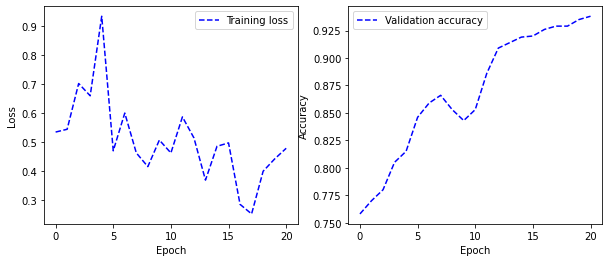

In [ ]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(loss_train, label="Training loss", color="blue", linestyle="dashed")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.subplot(1,2,2)
plt.plot(val_acc, label="Validation accuracy", color="blue", linestyle="dashed")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
check_performance(val_loader, model)

              precision    recall  f1-score   support

           0     0.9699    0.9539    0.9619       304
           1     0.9048    0.9652    0.9340       374
           2     0.9503    0.8913    0.9199       322

    accuracy                         0.9380      1000
   macro avg     0.9417    0.9368    0.9386      1000
weighted avg     0.9392    0.9380    0.9379      1000



## Save model

In [ ]:
model_dir = "/content/drive/MyDrive/Colab Notebooks/COMP4471/Project/efficientnet-b0-ckpt3.pth"

In [ ]:
torch.save(model.state_dict(), model_dir)

# Load model

In [ ]:
model_dir = "/content/drive/MyDrive/Colab Notebooks/COMP4471/Project/efficientnet-b0-ckpt3.pth"

In [ ]:
model = EfficientNet.from_name('efficientnet-b0', num_classes=3)

In [ ]:
model.load_state_dict(torch.load(model_dir))
#model.eval()

<All keys matched successfully>

In [ ]:
check_performance(val_loader, model.to(device))

              precision    recall  f1-score   support

           0     0.9699    0.9539    0.9619       304
           1     0.9048    0.9652    0.9340       374
           2     0.9503    0.8913    0.9199       322

    accuracy                         0.9380      1000
   macro avg     0.9417    0.9368    0.9386      1000
weighted avg     0.9392    0.9380    0.9379      1000



## Predict some examples

0: with mask, 1: incorrect_mask, 2: without_mask


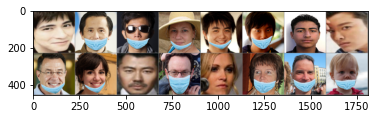

Predict: [2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 2, 1, 1, 1]
Labels: [2, 1, 1, 1, 1, 1, 2, 2, 1, 1, 2, 0, 2, 1, 1, 1]
CPU times: user 568 ms, sys: 79.7 ms, total: 648 ms
Wall time: 691 ms


In [ ]:
%%time
print("0: with mask, 1: incorrect_mask, 2: without_mask")
# get some random training images
dataiter = iter(val_loader)
images, labels = next(dataiter)

# show images
imshow(make_grid(images))

# print predictions
images = images.to(device=device, dtype=dtype)  # move to device, e.g. GPU
scores = model(images)
_, preds = scores.max(1)
print("Predict:", preds.tolist())

# print labels
print("Labels:",labels.squeeze(1).tolist())

## Predict on the test set

Run once for reporting the final pipeline

In [ ]:
check_performance(test_loader, model)